## Содержание

1. [Шаг 1. Загрузка данных](#read_data)
2. [Шаг 2. Исследовательский анализ данных (EDA)](#eda)
3. [Шаг 3. Построение модели прогнозирования оттока клиентов](#model)
4. [Шаг 4. Кластеризация клиентов](#clustering)
5. [Шаг 5. Общий вывод и базовые рекомендации по работе с клиентами](#conclusion)

# Прогнозирование оттока клиентов для фитнес-центра

Исследование проводится для сети фитнес-центров «Культурист-датасаентист», которая разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

**Задача** — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;
        
3) определить другие особенности взаимодействия с клиентами.

**Описание данных:**

    'Churn' — факт оттока в текущем месяце;
    Текущие поля в датасете:
        Данные клиента за предыдущий до проверки факта оттока месяц:
            'gender' — пол;
            'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
            'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
            Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
            'Phone' — наличие контактного телефона;
            'Age' — возраст;
            'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
    Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
        'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
        'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
        'Group_visits' — факт посещения групповых занятий;
        'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
        'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
        'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

# Шаг 1. Загрузка данных
<a name='read_data'></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

Изучим таблицу с информацией, типы данных, проверим наличие пропусков:

In [3]:
display(df.head())

df.info()

print(df.isna().sum())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Проверим таблицу на наличие дубликатов:

In [4]:
df.duplicated().sum()

0

**Итоги:**

- Некорректный формат в названиях колонок - необходимо привести к нижнему регистру.
- Типы данных представлены корректно.
- Пропусков нет, т.е. нет отсутствующих признаков.
- Дубликаты не найдены.

 Приведем названия колонок к нижнему регистру:

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns.to_list()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

# Шаг 2. Исследовательский анализ данных (EDA)
<a name='eda'></a>

Посмотрим на датасет: изучим средние значения и стандартные отклонения (метод describe()).

In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Итоги:**

- Среди клиентов фитнес-центра мужчин и женщин почти поровну.
- 85% клиентов живут рядом с фитнес-центром.
- Почти половина является сотрудниками компании-партнёра клуба.
- 30% клиентов записались в клуб в рамках акции «приведи друга».
- 90% посетителей оставили номер телефона.
- Абонемент в среднем берут сроком на 6 месяцев.
- 41% клиентов посещает групповые занятия.
- Средний возраст посетителей - 29 лет. Самому молодому - 18, а старшему - 41.
- Средняя суммарная выручка от других услуг фитнес-центра - 147 долларов, медианная - 136, а максимальная - 553 доллара.
- Срок до окончания текущего действующего абонемента (в месяцах) в среднем - 4 месяца, а максимальный - 12 месяцев.
- Длительность посещения клуба в среднем составляет 3,7 месяцев.
- Средняя частота посещений в неделю за все время и за месяц - 1-2 раза, а максимальное - 6.
- Прекращают посещать фитнес-центр в среднем 26% клиентов.

Касательно стандартных отклонений, у переменных они довольно разные по величине. В таких случаях их может быть необходимо стандартизировать перед обучением. Но мы будем использовать логистическую регрессию и случайный лес, а для этих моделей стандартизация не обязательна.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток - назовем столбец "churn", и тех, кто остался - назовем столбец "stayed" (метод groupby()).

In [8]:
churn_group = df.groupby('churn').mean().T
churn_group.columns = ['stayed', 'churn']
churn_group

,stayed,churn
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Выводы:**

Среди прекративших посещение равное количество мужчин и женщин.

Среди клиентов, которые продолжают посещения, больше тех, кто:

- живет поблизости от фитнес-центра,
- является сотрудниками компании-партнёра клуба,
- пришел по акции «приведи друга»,
- имеет более долгий срок абонемента (от полугода),
- посещает групповые занятия,
- около 30-ти лет и старше,
- больше тратится на дополнительные услуги клуба,
- имеет более долгий срок до окончания контракта (5-6 месяцев),
- дольше остается в клубе (4-5 месяцев),
- посещает фитнес хотя бы 2 раза в неделю.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток - "churn") и тех, кто остался (не попали в отток - "stayed"):

Text(0.5, 1.0, 'Распределение признаков для тех, кто ушёл, и тех, кто остался')

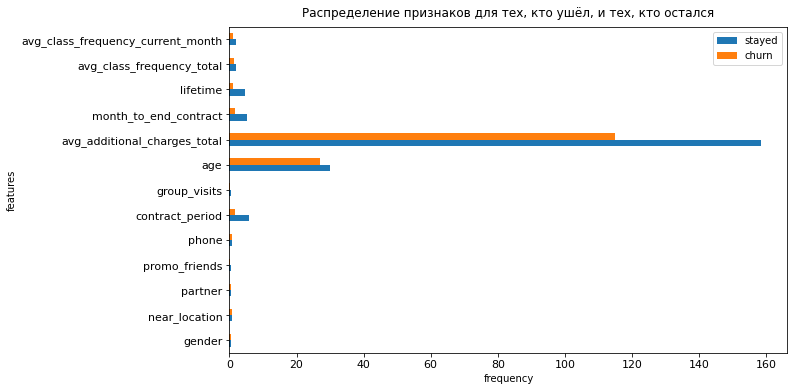

In [9]:
churn_group.plot(kind='barh',figsize=(10, 6), fontsize=11)
plt.xlabel('frequency')
plt.ylabel('features')
plt.title('Распределение признаков для тех, кто ушёл, и тех, кто остался', pad = 10)

Масштабируем график:

Text(0.5, 1.0, 'Распределение признаков для тех, кто ушёл, и тех, кто остался')

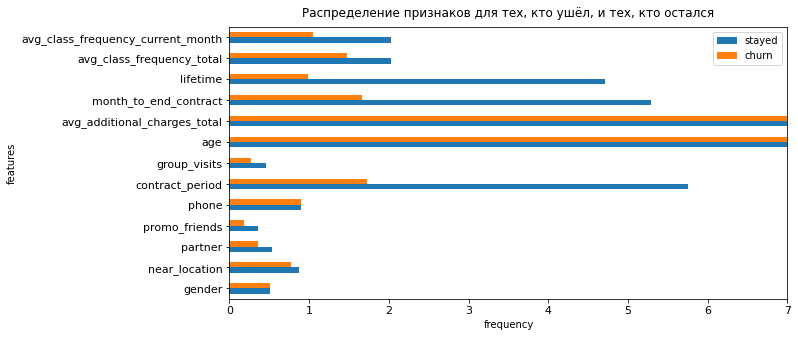

In [10]:
churn_group.plot(kind='barh',figsize=(10, 5), fontsize=11)
plt.xlim(0, 7)
plt.xlabel('frequency')
plt.ylabel('features')
plt.title('Распределение признаков для тех, кто ушёл, и тех, кто остался', pad = 10)

**Выводы:**

Признаки, более всего указывающие на то, что клиент останется:

- длительное посещение клуба,
- долгий срок до окончания текущего действующего абонемента,
- более крупные траты на дополнительные услуги клуба,
- более старший возраст (от 30-ти лет),
- более долгий срок абонемента.

Построим попарные диаграммы рассеяния "признак-целевая переменная для каждого признака".

Значения на оси y: 0.0 - клиент остался, 1.0 - клиент ушел.

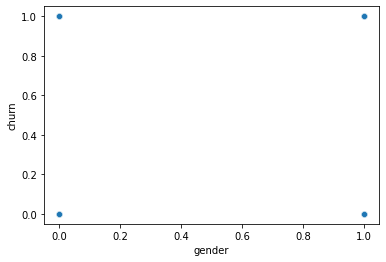

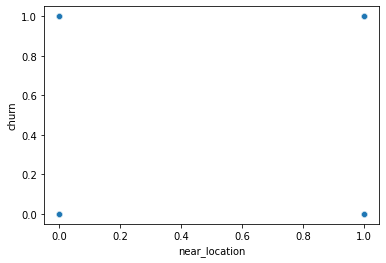

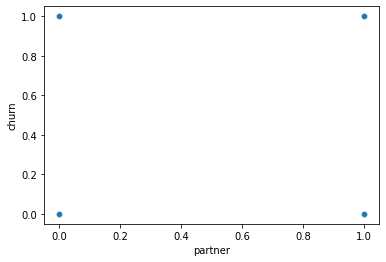

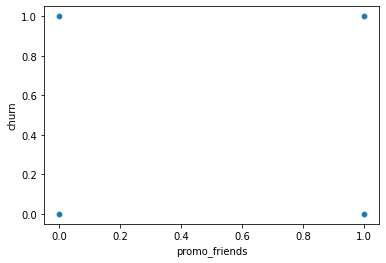

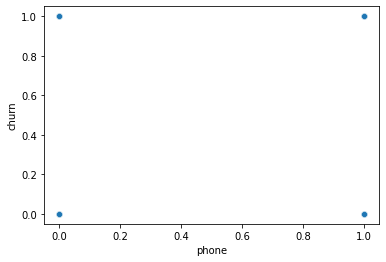

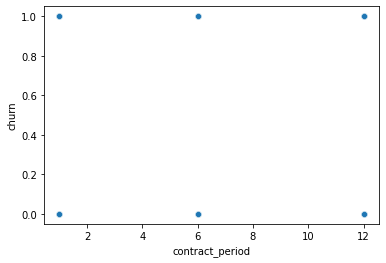

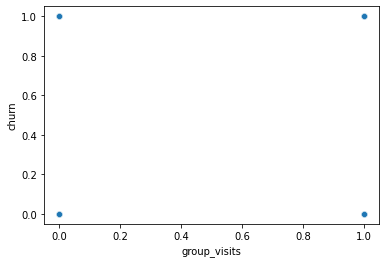

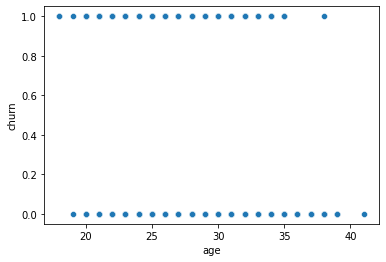

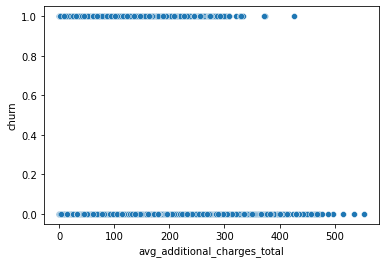

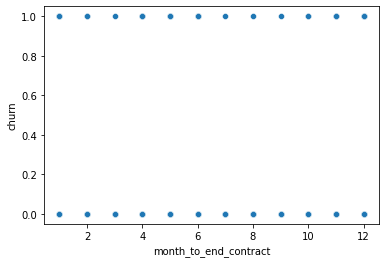

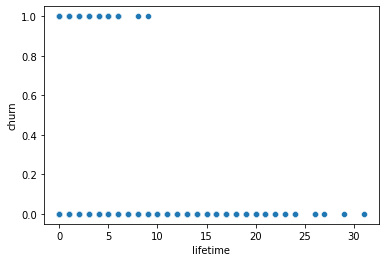

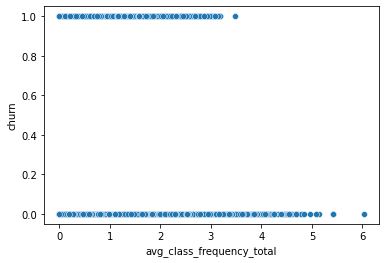

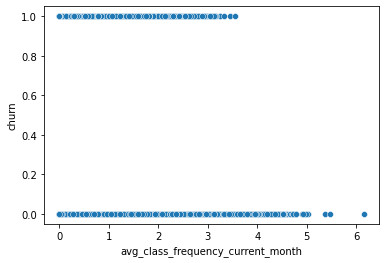

In [11]:
for col in df.drop('churn', axis = 1).columns:
    sns.scatterplot(x=df[col], y=df['churn'])
    plt.show()

Видим, что на диаграммах рассеяния отражаются выводы, сделанные по таблице churn_group.

Построим и отобразим матрицу корреляций:

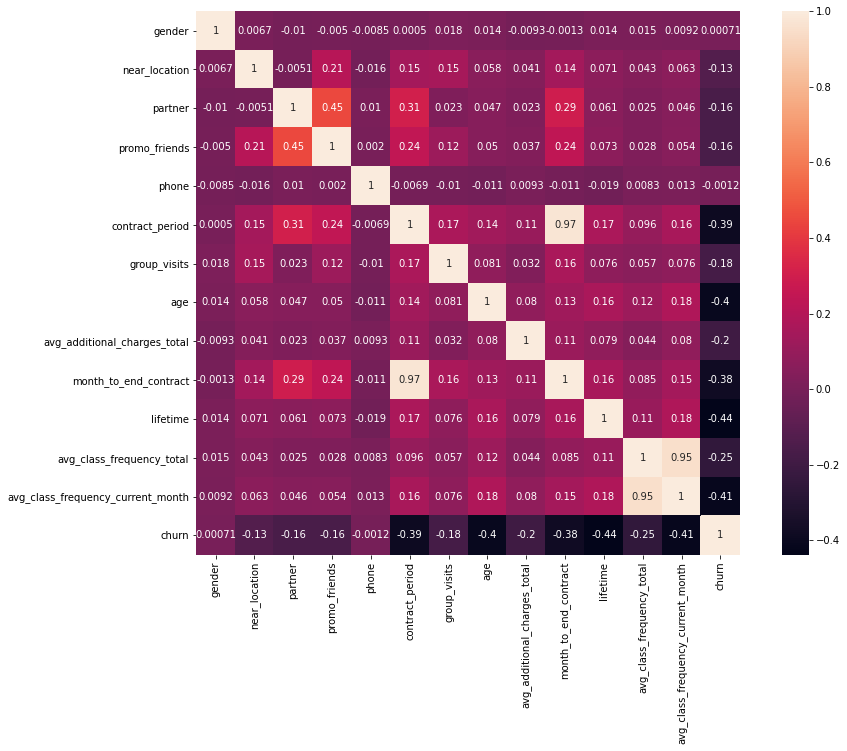

In [12]:
cm = df.corr() #вычисляем матрицу корреляций

#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(15, 10))

sns.heatmap(cm, annot=True, square=True)
plt.show()

**Вывод:**

Диаграммы рассеяния отражают выводы, сделанные по таблице churn_group.
Сильных выбросов не наблюдается. 

По тепловой карте особой корреляции не заметно.

Такие признаки как contract_period и month_to_end_contract, и avg_class_frequency_current_month и avg_class_frequency_total коррелируют хорошо, т.к. относятся к одной категории.

Признак contract_period более-менее коррелирует с признаками partner и promo_friends, возможно, это связано с мотивацией продолжать занятия.

# Шаг 3. Построение модели прогнозирования оттока клиентов
<a name='model'></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

- Разобьём данные на обучающую и валидационную выборку функцией train_test_split().

In [13]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn'], axis=1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

- Обучим модель на train-выборке двумя способами:

    - логистической регрессией,
    - случайным лесом.
    
    
- Оценим метрики *accuracy, precision* и *recall* для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

In [14]:
# определим функцию, которая будет выводить нужные метрики
def print_all_metrics(y_test, predictions, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))

**Логистическая регрессия:**

In [15]:
# зададим алгоритм для нашей модели
lr_model = LogisticRegression(random_state=0, solver='liblinear')

# обучим модель
lr_model.fit(X_train, y_train)

# бинарный прогноз
lr_predictions = lr_model.predict(X_test)

In [16]:
# выведем метрики
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83


**Случайный лес:**

In [17]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)

In [18]:
# выведем метрики
print_all_metrics(
    y_test,
    rf_predictions, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


**Вывод:**

Логистическая регрессия оказалась сильнее по метрикам, т.к. они у неё ближе к единице, чем метрики случайного леса.

# Шаг 4. Кластеризация клиентов
<a name='clustering'></a>

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов):

   - Стандартизируем данные.
   - Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

In [19]:
#удаляем столбец с оттоком (целевой переменной)
df_new=df.drop('churn', axis=1)

# стандартизаруем данные
sc = StandardScaler()
X_sc = sc.fit_transform(df_new)

# в переменной linked сохраняем таблица «связок» между объектами
linked = linkage(X_sc, method = 'ward')

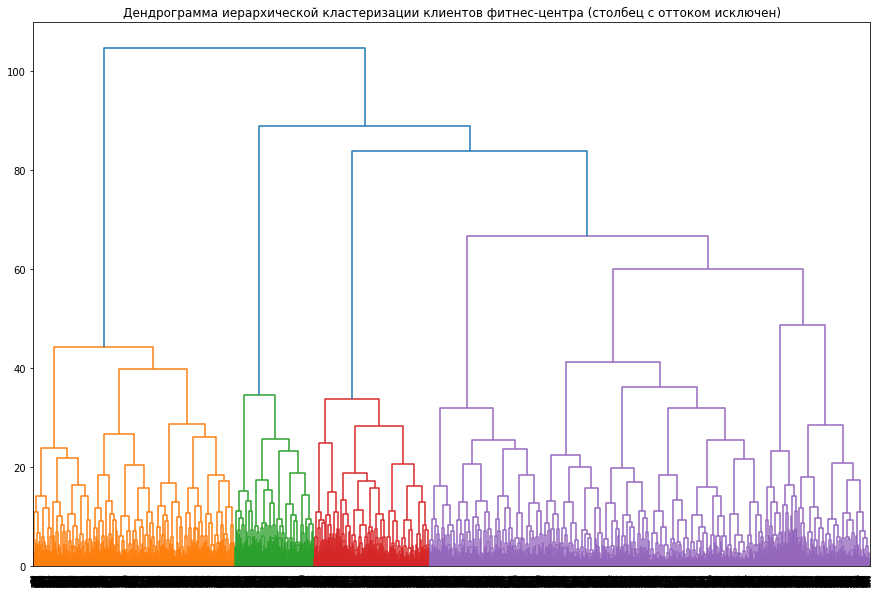

In [20]:
# визуализируем linked как дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнес-центра (столбец с оттоком исключен)')
plt.show()

Дендрограмма отобразила 4 кластера разного цвета. Но по условию задачи требуется 5.

- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5.

In [21]:
# стандартизируем данные
sc_km = StandardScaler()
x_sc_km = sc_km.fit_transform(df_new)

# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc_km)

# сохраняем метки кластера в поле датасета
df['cluster_km'] = labels

In [22]:
# выводим статистику по средним значениям признаков по кластеру, сбросив индексы
clusters = df.groupby(['cluster_km']).mean().reset_index()
clusters

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


In [23]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


Для удобства транспонируем таблицу и переименуем столбцы с кластерами:

In [24]:
clusters_t = clusters.T
clusters_t

,0,1,2,3,4
cluster_km,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905


- Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

Судя по средним значениям признаков, под описание клиентов, которые продолжают посещать фитнес-центр, подходят кластеры 0, 1 и 4.

Они живут недалеко от клуба, посещают групповые занятия, их средний возраст 29-30 лет, они больше тратятся на дополнительные услуги, продолжительно посещают фитнес-центр (4-5 месяцев).

Большая часть кластера 0 является сотрудниками компании-партнёра клуба, а многие пришли по акции «приведи друга», у них большой срок до окончания абонемента (10-11 месяцев).

Также, клиенты, вошедшие в кластеры 0, 1 и 4, ходят на фитнес чаще клиентов из других кластеров (2 раза в неделю в среднем).

И самый большой отток наблюдается в кластерах 2 и 3, а в кластерах 0 и 4 - самый маленький.

- Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?

*scatterplot:*

In [25]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

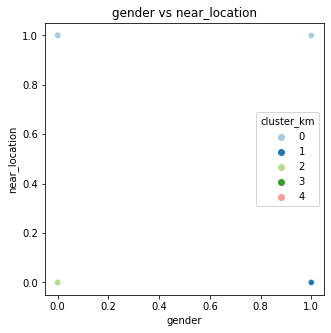

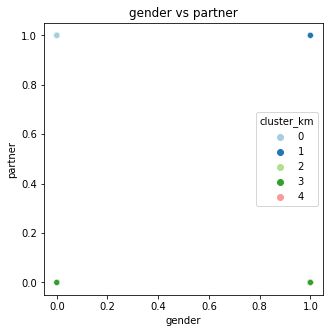

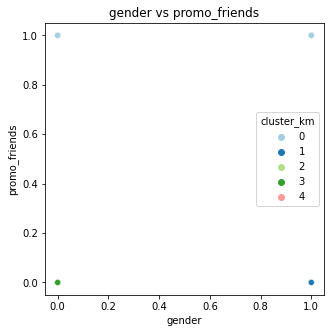

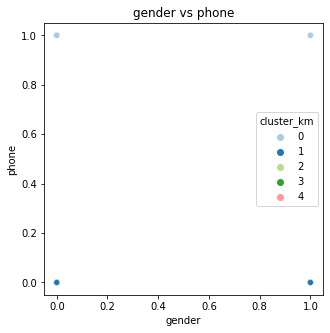

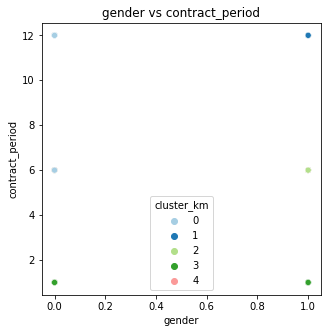

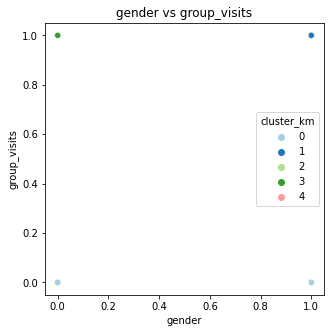

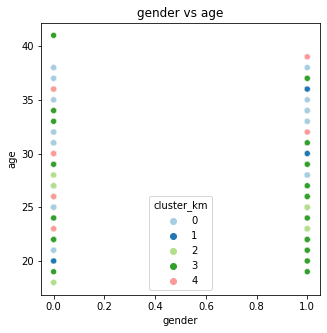

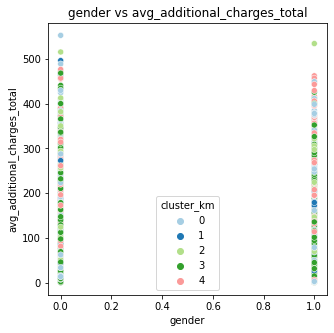

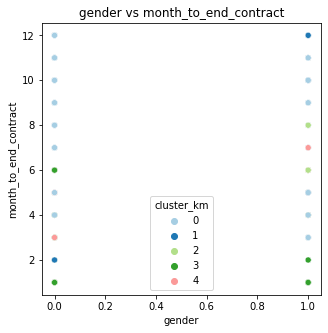

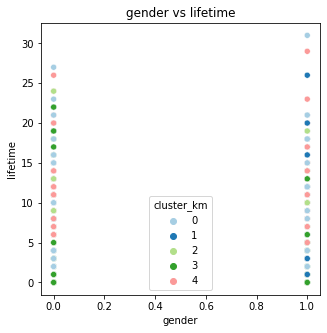

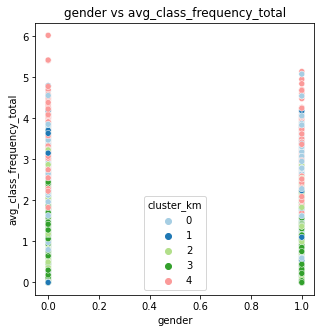

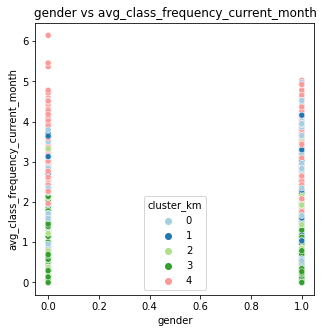

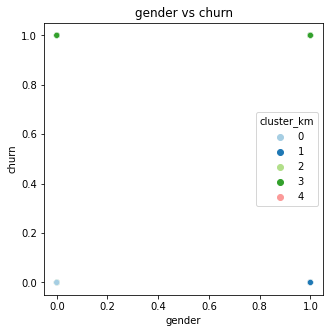

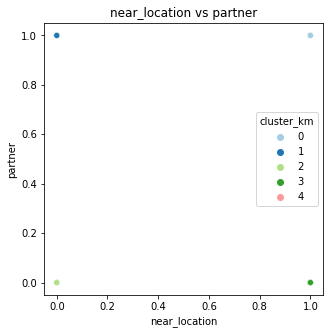

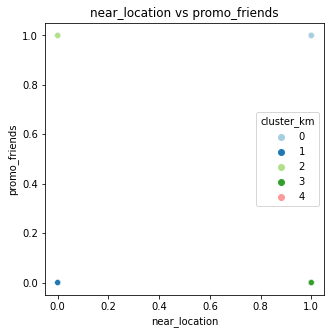

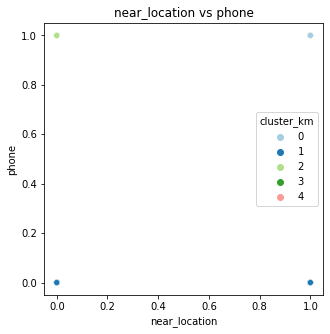

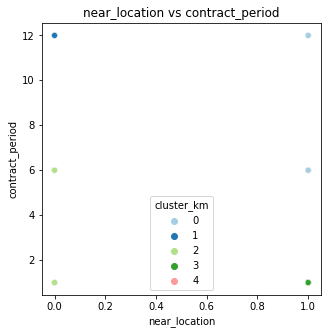

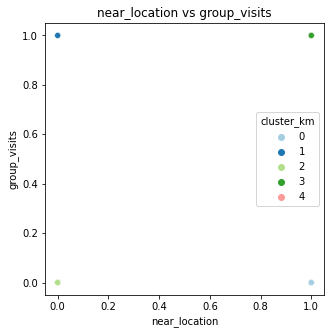

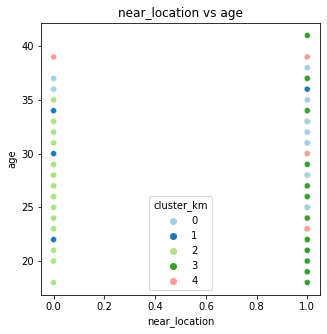

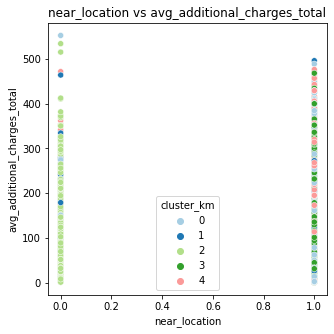

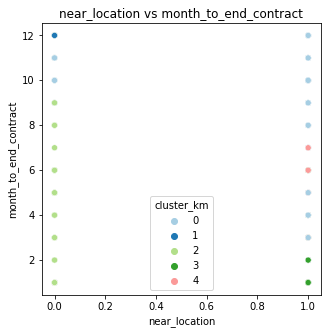

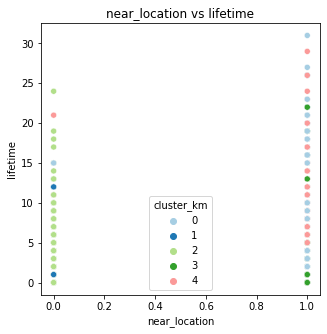

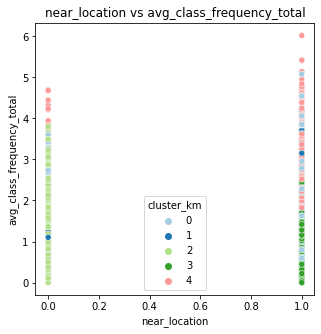

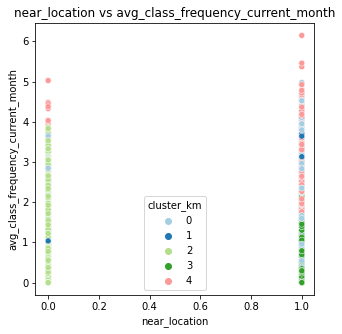

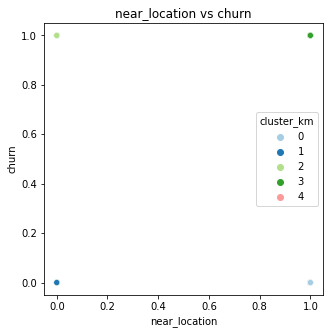

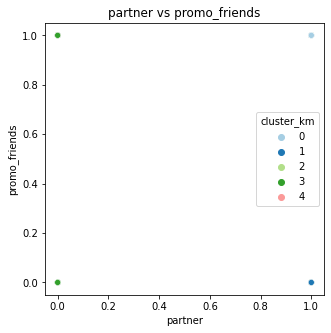

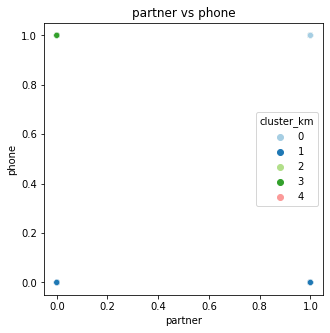

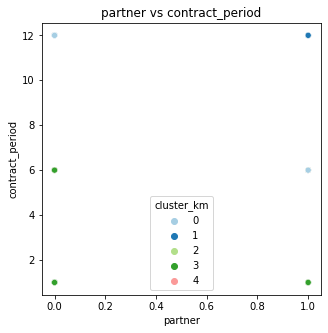

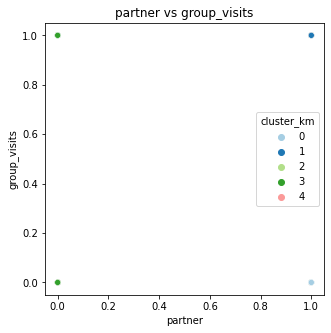

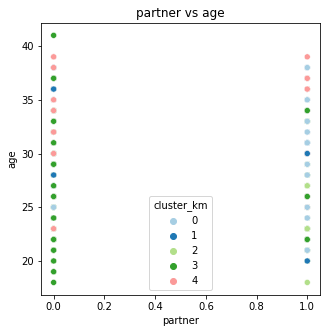

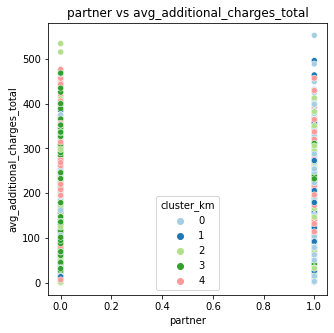

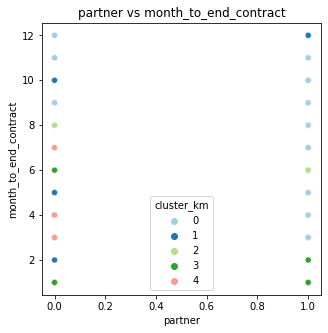

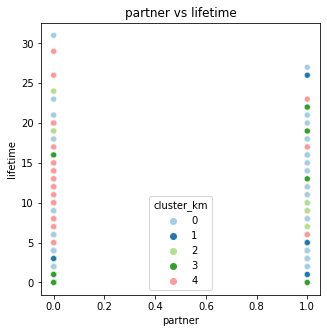

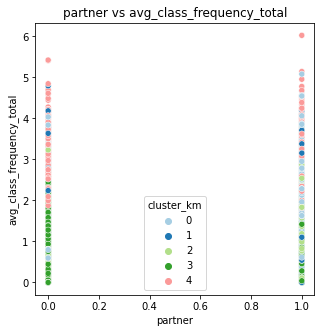

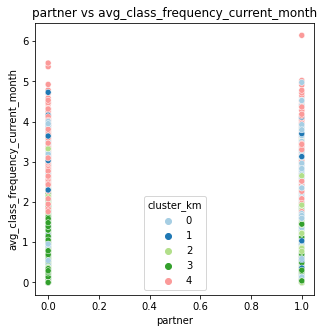

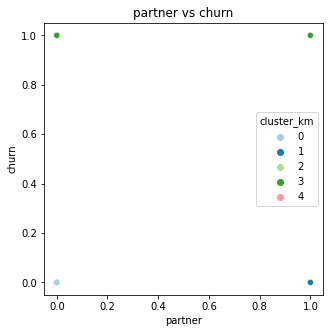

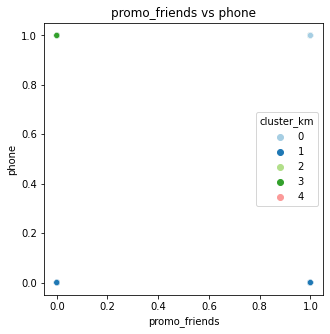

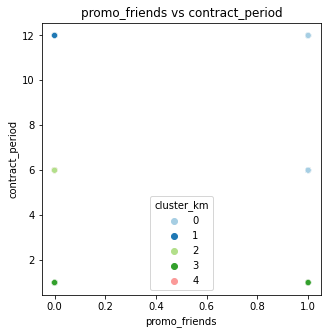

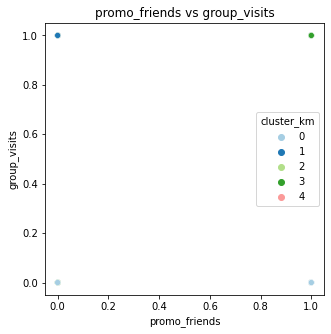

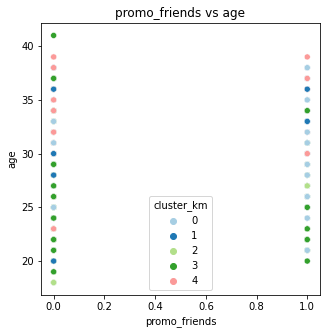

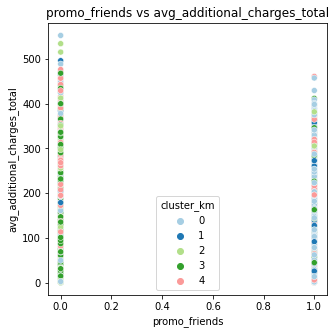

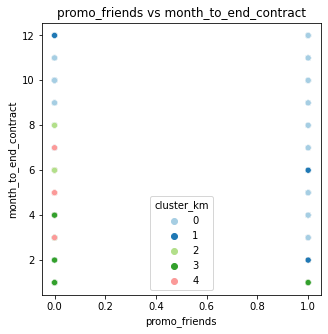

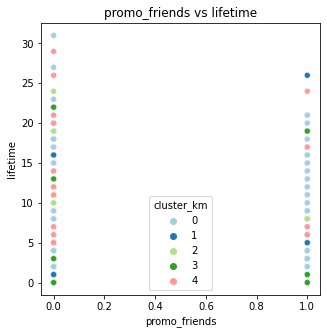

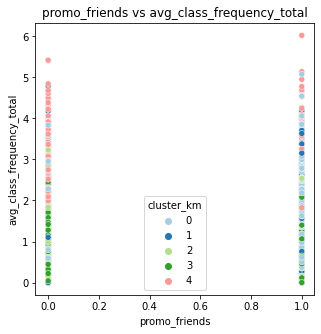

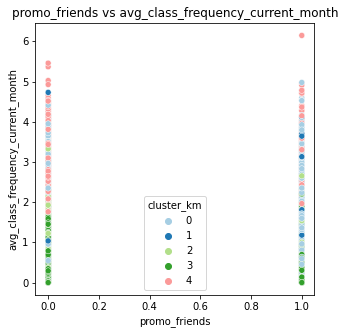

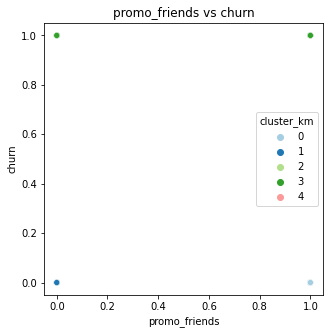

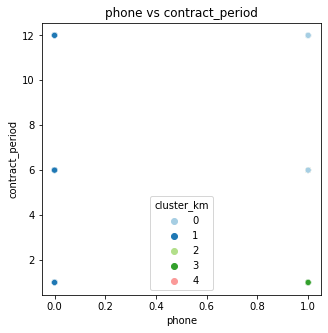

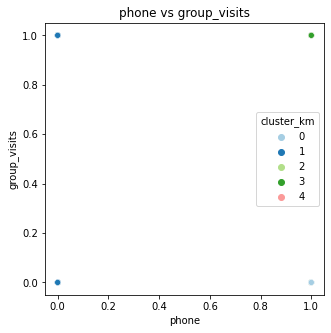

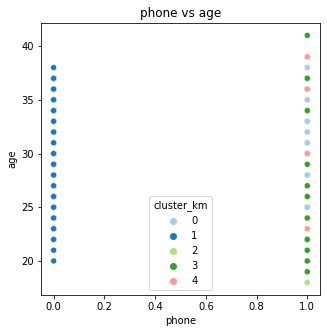

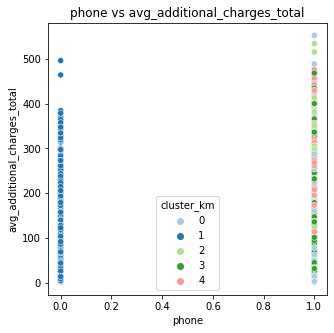

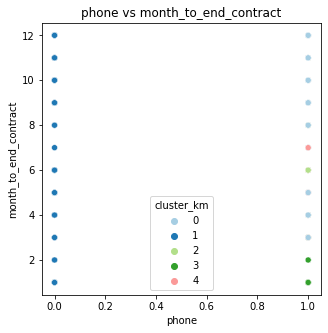

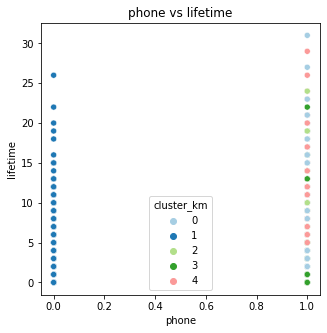

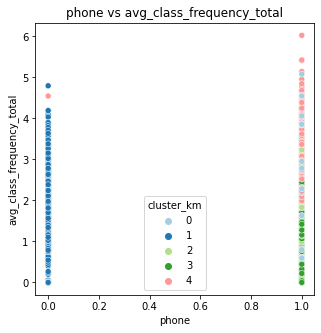

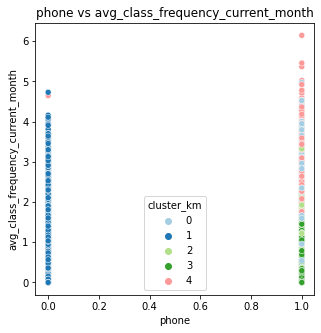

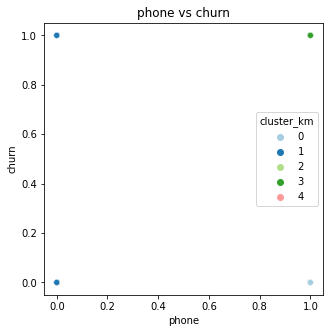

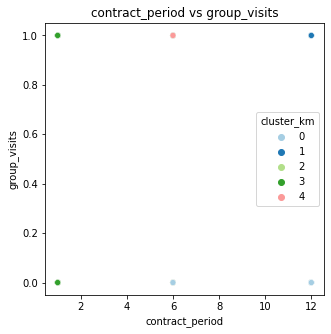

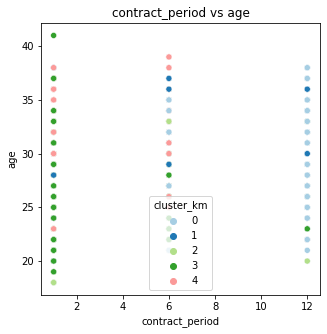

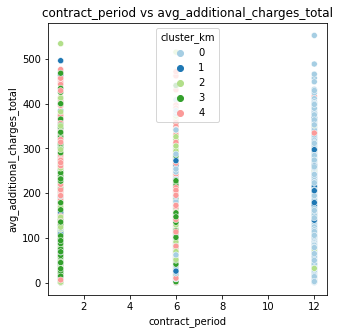

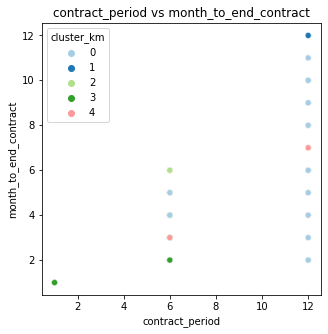

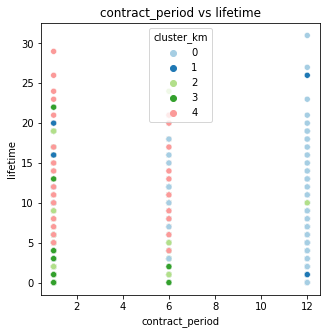

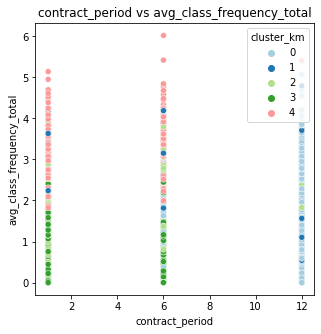

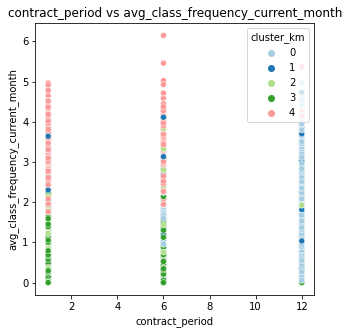

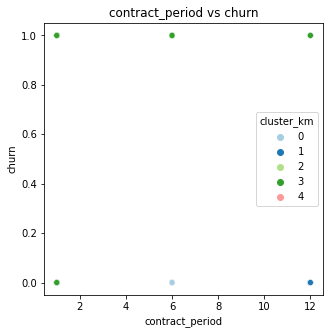

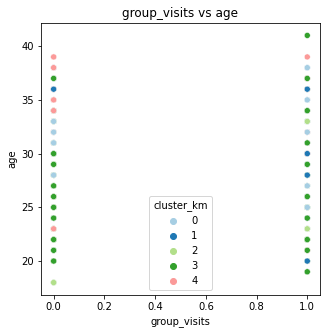

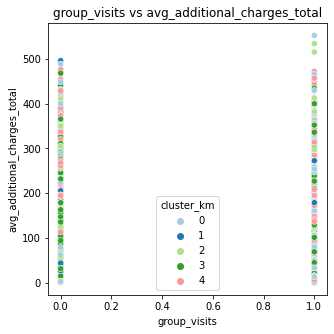

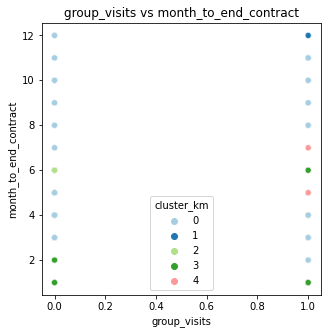

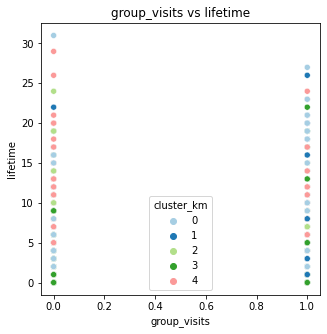

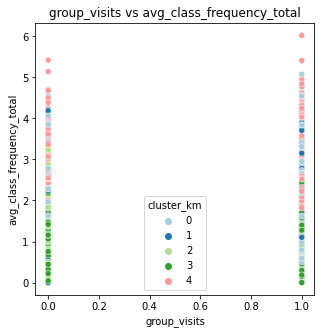

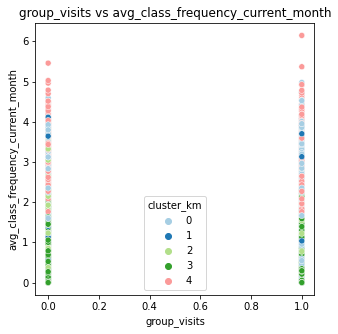

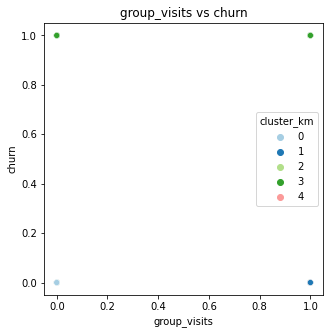

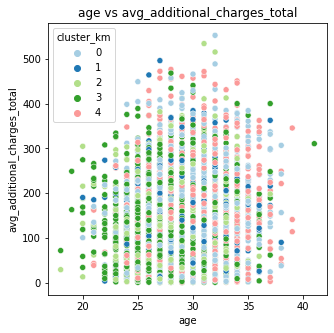

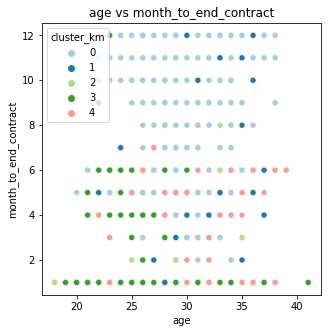

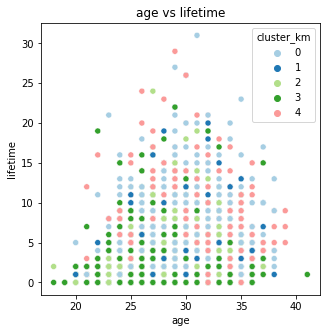

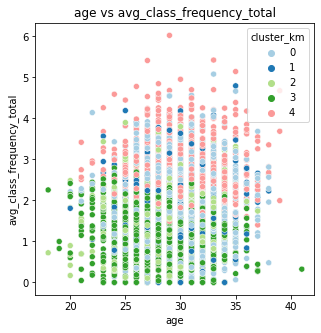

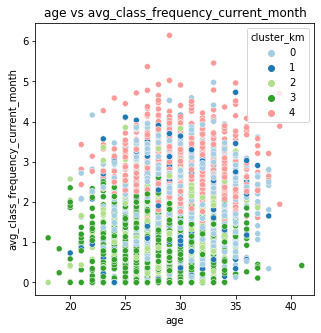

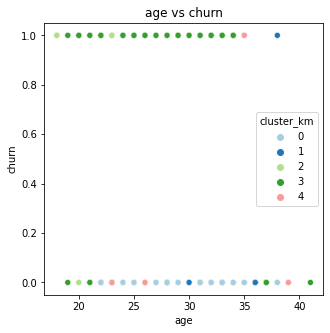

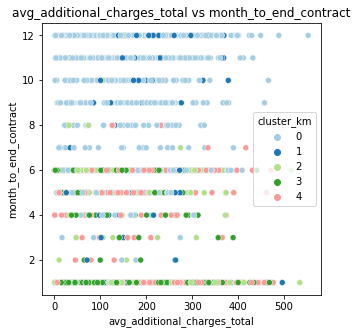

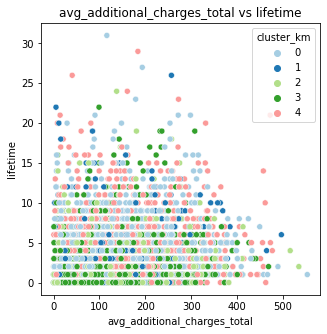

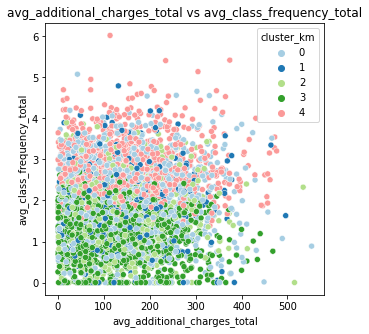

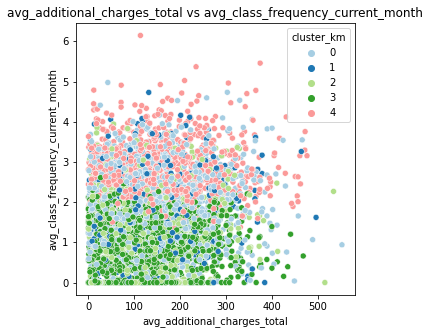

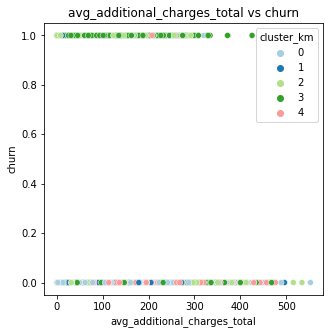

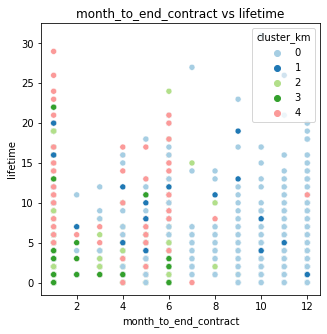

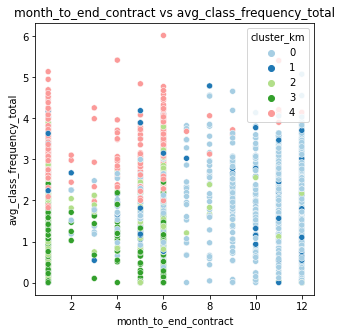

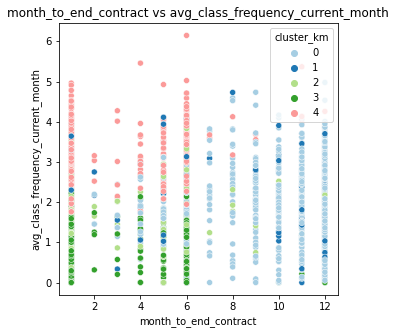

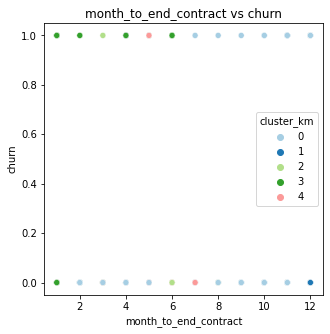

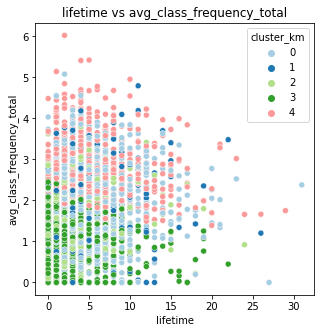

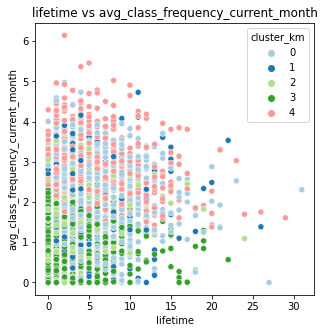

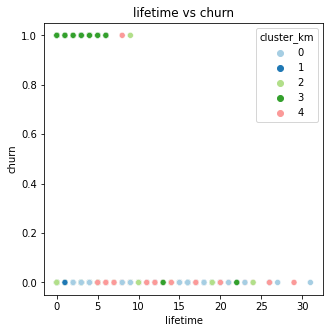

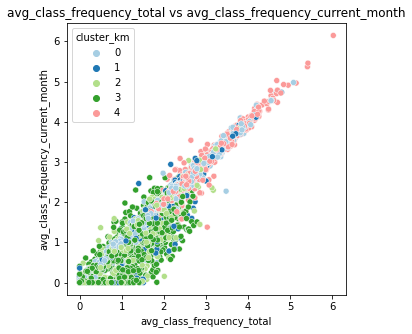

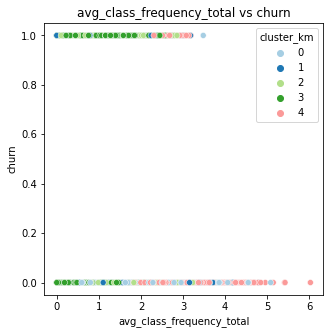

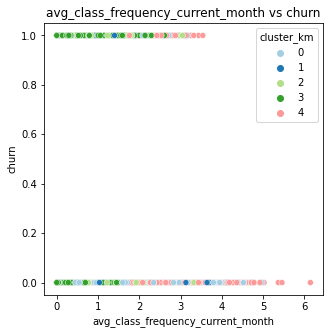

In [26]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_km')

*countplot (для дискретных переменных):*

<AxesSubplot:xlabel='near_location', ylabel='count'>

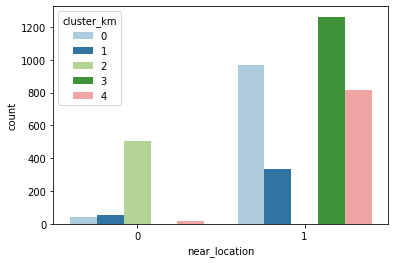

In [27]:
sns.countplot(data = df, x = 'near_location', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='partner', ylabel='count'>

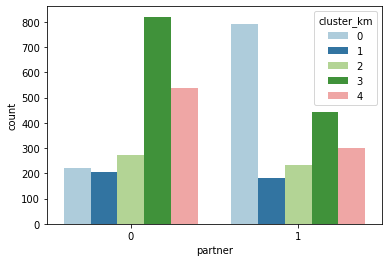

In [28]:
sns.countplot(data = df, x = 'partner', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='promo_friends', ylabel='count'>

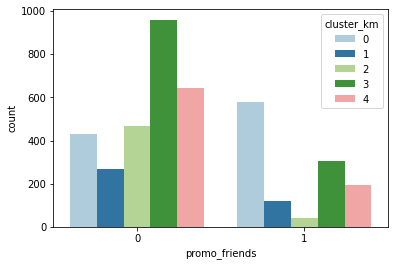

In [29]:
sns.countplot(data = df, x = 'promo_friends', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='contract_period', ylabel='count'>

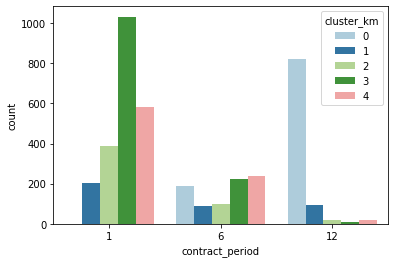

In [30]:
sns.countplot(data = df, x = 'contract_period', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='month_to_end_contract', ylabel='count'>

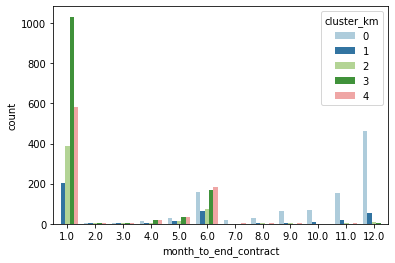

In [31]:
sns.countplot(data = df, x = 'month_to_end_contract', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='group_visits', ylabel='count'>

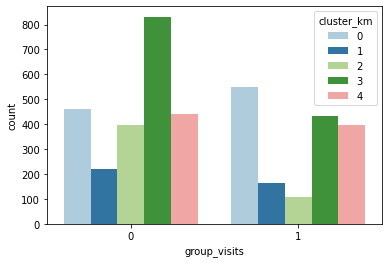

In [32]:
sns.countplot(data = df, x = 'group_visits', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='age', ylabel='count'>

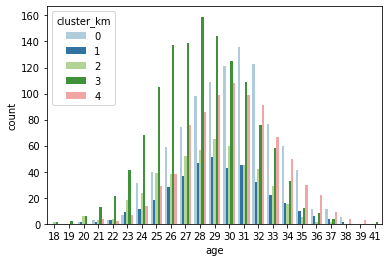

In [33]:
sns.countplot(data = df, x = 'age', hue = 'cluster_km', palette='Paired')

<AxesSubplot:xlabel='churn', ylabel='count'>

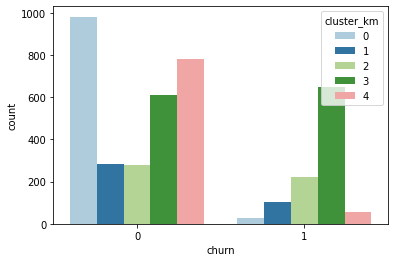

In [34]:
sns.countplot(data = df, x = 'churn', hue = 'cluster_km', palette='Paired')

*boxplot (для непрерывных переменных):*

<AxesSubplot:xlabel='cluster_km', ylabel='avg_additional_charges_total'>

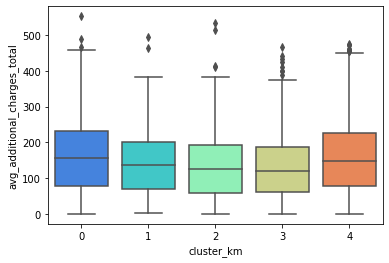

In [35]:
sns.boxplot(x ='cluster_km',y = 'avg_additional_charges_total', data = df, palette='rainbow')

<AxesSubplot:xlabel='cluster_km', ylabel='lifetime'>

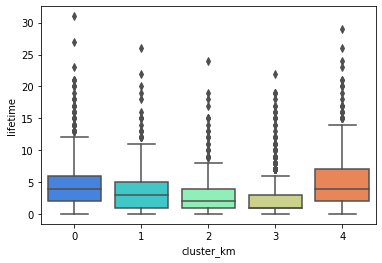

In [36]:
sns.boxplot(x ='cluster_km',y = 'lifetime', data = df, palette='rainbow')

<AxesSubplot:xlabel='cluster_km', ylabel='avg_class_frequency_total'>

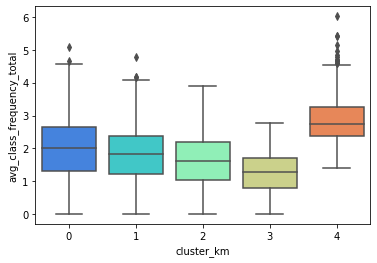

In [37]:
sns.boxplot(x ='cluster_km',y = 'avg_class_frequency_total', data = df, palette='rainbow')

**Вывод**

*График scatterplot*:

Хорошо прослеживается связь между 3-мя признаками (признаки по осям графика и номер кластера) на следующих графиках:

age vs avg_additional_charges_total: больше всего дополнительно тратятся посетители от 26-ти до 36-ти лет. Среди них заметно много клиентов из кластеров 0 и 4. Клиенты до 30-ти лет из кластеров 2 и 3 тратят немного.

age vs month_to_end_contract: большой срок до окончания абонемента у клиентов из кластера 0, маленький - в основном у клиентов из 3-го кластера.

age vs lifetime: дольше на фитнес ходят клиенты в районе 30-ти лет. Основная их масса принадлежит к кластерам 0 и 4. Клиенты 3-го кластера в основной массе моложе и посещают фитнес непродолжительно.

age vs avg_class_frequency_total: чаще всего ходят на фитнес люди в районе 30-ти лет из кластеров 0 и 4: 2-4 раза в неделю.

Самый большой отток клиентов наблюдается в 3-м кластере.

*Графики countplot и boxplot:*

Заметно, как лидируют кластеры 0, 1 и 4 по признакам, присутствующим у клиентов, которые остаются в фитнесе.

- Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

Сначала сгруппируем таблицу по кластерам и посчитаем количество ушедших клиентов. Запишем таблицу в переменную if_churn:

In [38]:
if_churn = df.query('churn==1').groupby('cluster_km')['gender'].count()
if_churn

cluster_km
0     28
1    103
2    224
3    649
4     57
Name: gender, dtype: int64

Вычислим долю ушедших клиентов для каждого кластера:

In [39]:
clusters['part'] = round((if_churn / df.shape[0] * 100), 2)
clusters

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,part
0,0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723,0.70
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532,2.58
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564,5.60
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263,16.23
4,4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019,1.42


**Вывод:**

Доля оттока клиентов для кластеров:

- 0: 0.70 %
- 1: 2.58 %
- 2: 5.60 %
- 3: 16.23 %
- 4: 1.42 %

И снова в 1-м и 3-ем кластерах подтверждается больший отток клиентов. А клиенты во 2-м, 4-м и 5-м кластерах надёжны.

# Шаг 5. Общий вывод и базовые рекомендации по работе с клиентами
<a name='conclusion'></a>

**Портреты клиентов:**

- Среди клиентов фитнес-центра мужчин и женщин почти поровну.
- 85% клиентов живут рядом с фитнес-центром.
- Почти половина является сотрудниками компании-партнёра клуба.
- 30% клиентов записались в клуб в рамках акции «приведи друга».
- 90% посетителей оставили номер телефона.
- Абонемент в среднем берут сроком на 6 месяцев.
- 41% клиентов посещает групповые занятия.
- Средний возраст посетителей - 29 лет. Самому молодому - 18, а старшему - 41.
- Средняя суммарная выручка от других услуг фитнес-центра - 147 долларов, медианная - 136, а максимальная - 553 доллара.
- Срок до окончания текущего действующего абонемента (в месяцах) в среднем - 4 месяца, а максимальный - 12 месяцев.
- Длительность посещения клуба в среднем составляет 3,7 месяцев.
- Средняя частота посещений в неделю за все время и за месяц - 1-2 раза, а максимальное - 6.
- Прекращают посещать фитнес-центр в среднем 26% клиентов. Из них мужчин и женщин поровну.

**Среди клиентов, которые продолжают посещения, больше тех, кто:**

- живет поблизости от фитнес-центра,
- является сотрудниками компании-партнёра клуба,
- пришел по акции «приведи друга»,
- имеет более долгий срок абонемента (от полугода),
- посещает групповые занятия,
- около 30-ти лет и старше,
- больше тратится на дополнительные услуги клуба,
- имеет более долгий срок до окончания контракта (5-6 месяцев),
- дольше остается в клубе (4-5 месяцев),
- посещает фитнес хотя бы 2 раза в неделю.

**Признаки, отмеченные у ушедших клиентов:**

- непродолжительное посещение клуба,
- проживание дальше от фитнес-центра,
- небольшой срок до окончания текущего действующего абонемента,
- меньшие траты на дополнительные услуги клуба,
- возраст младше 29-ти лет,
- более короткий срок абонемента,
- посещение фитнеса меньше 2-х раз в неделю.

**Рекомендации:**

- сделать упор на привлечение компаний-партнёров клуба,
- усилить выгоду для клиентов, пришедших в рамках акции «приведи друга»,
- проводить рекламные кампании для групповых занятий,
- разработать систему поощрений для клиентов, купивших абонемент на более длительный срок.